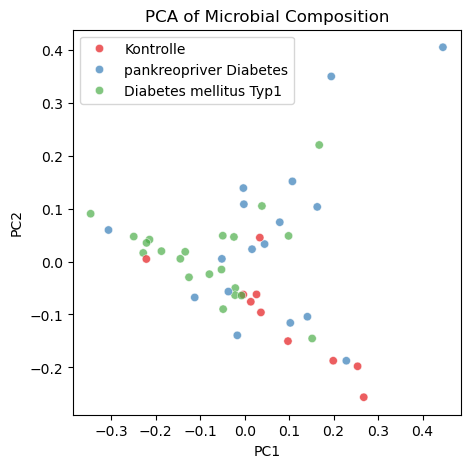

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load the dataset
file_path = "level-4.csv"
df = pd.read_csv(file_path)

# Extract metadata and microbial abundance data
metadata_cols = ["index", "sample_information", "condition", "nikotin", "sex", "age_group", "AH"]
microbial_data = df.drop(columns=metadata_cols, errors='ignore')

# Extract only microbial taxa names (last part of taxonomy string)
def extract_species_name(taxonomy):
    """Extract the last part of a taxonomy string (genus name)."""
    return taxonomy.split(';')[-1].strip()

microbial_data.rename(columns={col: extract_species_name(col) for col in microbial_data.columns}, inplace=True)

# Normalize microbial abundances (convert to relative abundance)
microbial_data = microbial_data.div(microbial_data.sum(axis=1), axis=0)

# Add condition column back for grouping
microbial_data["condition"] = df["condition"]

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(microbial_data.drop(columns=["condition"], errors='ignore'))

# Create PCA DataFrame for visualization
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["condition"] = df["condition"]

# Plot PCA results
plt.figure(figsize=(5, 5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="condition", palette="Set1", alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Microbial Composition")
plt.legend(title="")
plt.show()


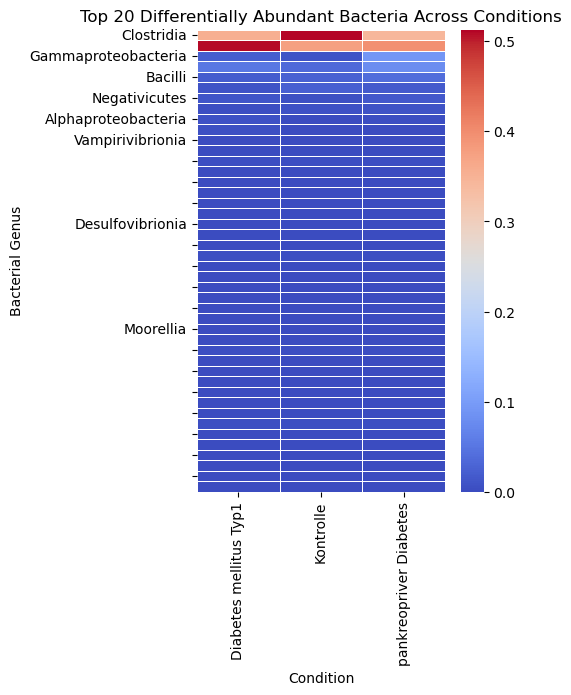

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "level-3.csv"
df = pd.read_csv(file_path)

# Extract microbial abundance data (exclude metadata)
metadata_cols = ["index", "sample_information", "condition", "nikotin", "sex", "age_group", "AH"]
microbial_data = df.drop(columns=metadata_cols, errors='ignore')

# Extract only microbial taxa names (last part of taxonomy string)
def extract_species_name(taxonomy):
    """Extract the last part of a taxonomy string (genus name)."""
    return taxonomy.split(';')[-1].strip()

microbial_data.rename(columns={col: extract_species_name(col) for col in microbial_data.columns}, inplace=True)

# Normalize microbial abundances (convert to relative abundance)
microbial_data = microbial_data.div(microbial_data.sum(axis=1), axis=0)

# Add condition column back for grouping
microbial_data["condition"] = df["condition"]

# Compute mean abundance for each bacterial taxa per condition
condition_means = microbial_data.groupby("condition").mean()

# Identify the top 20 differentially abundant bacteria
top_bacteria = condition_means.var(axis=0).nlargest(20).index  # Select the 20 taxa with the highest variance

# Filter dataset for the selected taxa
heatmap_data = condition_means[top_bacteria]

# Plot heatmap
plt.figure(figsize=(4, 6))
sns.heatmap(heatmap_data.T, cmap="coolwarm", annot=False, linewidths=0.5)

# Labels and title
plt.title("Top 20 Differentially Abundant Bacteria Across Conditions")
plt.xlabel("Condition")
plt.ylabel("Bacterial Genus")
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Show plot
plt.show()


/tmp/ipykernel_2256085/2373000367.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=microbial_data["condition"], y=microbial_data[taxon], palette=custom_palette, ax=ax)
/tmp/ipykernel_2256085/2373000367.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_2256085/2373000367.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=microbial_data["condition"], y=microbial_data[taxon], palette=custom_palette, ax=ax)
/tmp/ipykernel_2256085/2373000367.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

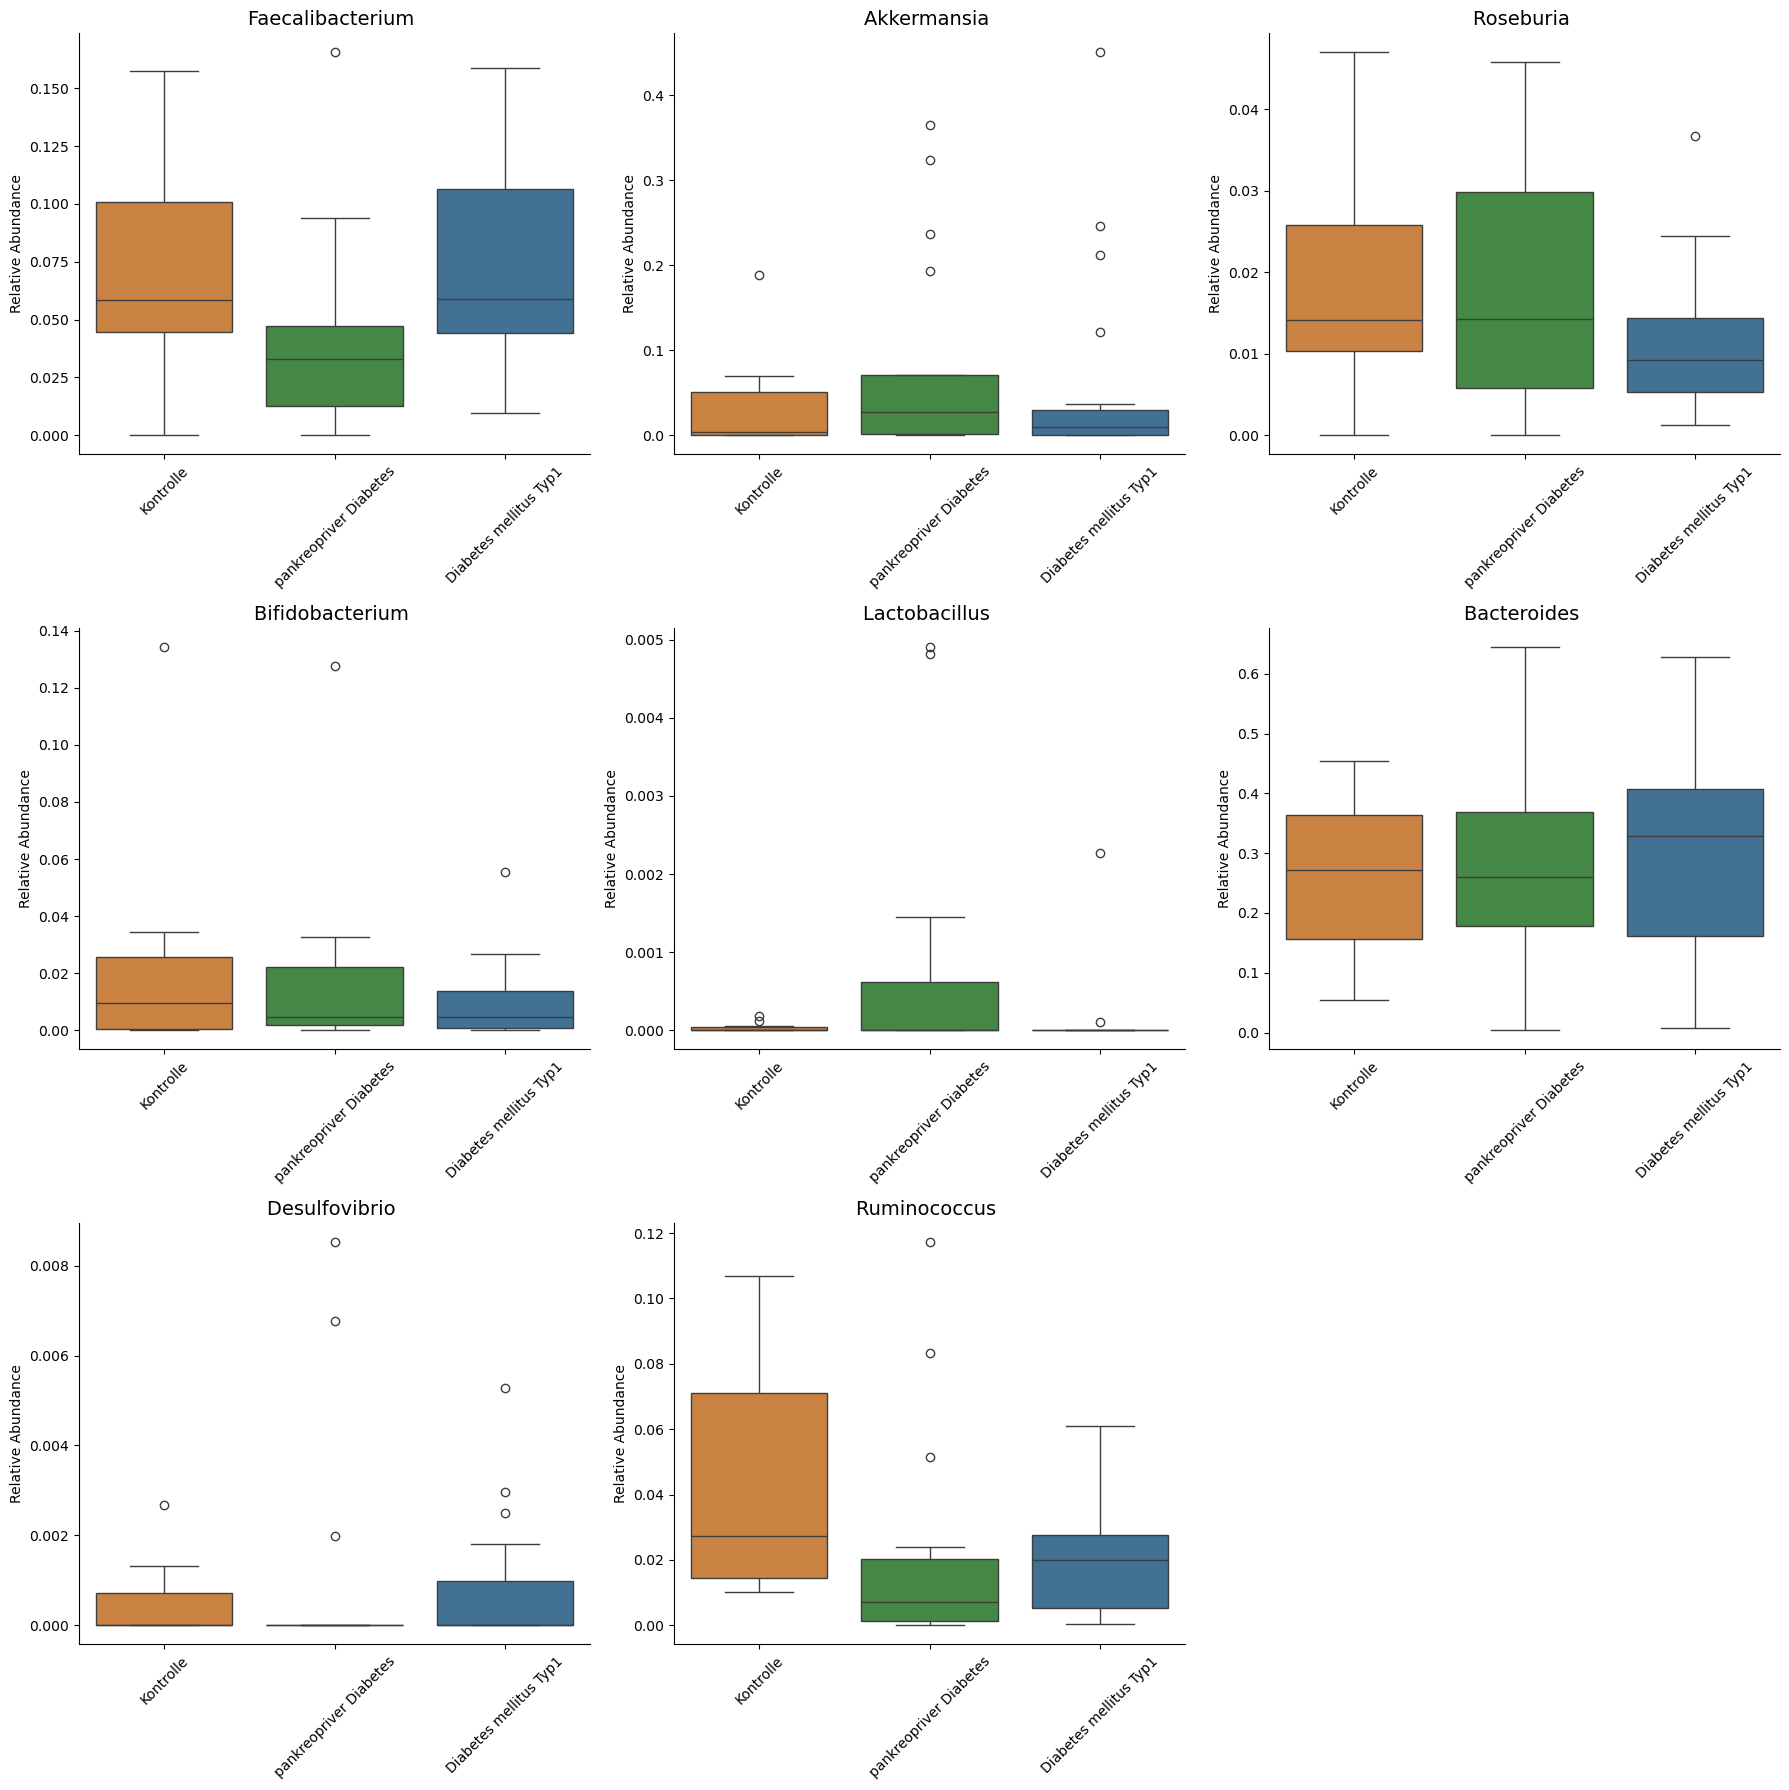

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Load the dataset
file_path = "level-6.csv"
df = pd.read_csv(file_path)

# Extract microbial abundance data (exclude metadata)
metadata_cols = ["index", "sample_information", "condition", "nikotin", "sex", "age_group", "AH"]
microbial_data = df.drop(columns=metadata_cols, errors='ignore')

# Extract only microbial taxa names (last part of taxonomy string)
def extract_species_name(taxonomy):
    """Extract the last part of a taxonomy string (genus name)."""
    return taxonomy.split(';')[-1].strip()

microbial_data.rename(columns={col: extract_species_name(col) for col in microbial_data.columns}, inplace=True)

# Remove empty column names ("")
microbial_data = microbial_data.loc[:, microbial_data.columns != ""]

# Normalize microbial abundances (convert to relative abundance)
microbial_data = microbial_data.div(microbial_data.sum(axis=1), axis=0)

# Add condition column back for grouping
microbial_data["condition"] = df["condition"]

# Define key taxa related to insulin loss
protective_taxa = ["Faecalibacterium", "Akkermansia", "Roseburia", "Bifidobacterium", "Lactobacillus"]
pathogenic_taxa = ["Bacteroides", "Desulfovibrio", "Ruminococcus"]
all_taxa = protective_taxa + pathogenic_taxa

# Define condition colors
custom_palette = {"Diabetes mellitus Typ1": "#3374A1", "Kontrolle": "#E1812C", "pankreopriver Diabetes": "#3A923A"}

# Define condition groups for statistical comparisons
pairs = [("Kontrolle", "pankreopriver Diabetes"), ("Kontrolle", "Diabetes mellitus Typ1"), ("pankreopriver Diabetes", "Diabetes mellitus Typ1")]

# Function to compute p-values
def compute_pval(data, taxon, group1, group2):
    """Compute Mann-Whitney U test p-value between two groups."""
    x = data[data["condition"] == group1][taxon]
    y = data[data["condition"] == group2][taxon]
    
    if len(x) > 0 and len(y) > 0:
        stat, p = mannwhitneyu(x, y, alternative="two-sided")
        return p
    else:
        return None

# Set up subplots (3 plots per row)
n_taxa = len(all_taxa)
n_cols = 3
n_rows = (n_taxa // n_cols) + (n_taxa % n_cols > 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten()

# Generate boxplots with only statistical significance stars
for i, taxon in enumerate(all_taxa):
    if taxon in microbial_data.columns:
        ax = axes[i]
        sns.boxplot(x=microbial_data["condition"], y=microbial_data[taxon], palette=custom_palette, ax=ax)
        ax.set_title(f"{taxon} ", fontsize=14)
        ax.set_xlabel("")
        ax.set_ylabel("Relative Abundance")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

        # Remove plot frame
        sns.despine(ax=ax)

        #Compute and annotate p-values (Stars only, No Bars)
        y_max = microbial_data[taxon].max()
        height = (y_max *0.02)  # Space above the boxes for annotation
        shift = -0.4  # Rightward shift for better spacing
        
        for j, (g1, g2) in enumerate(pairs):
            pval = compute_pval(microbial_data, taxon, g1, g2)
            if pval is not None:
                # Determine significance level
                significance = "ns" if pval > 0.05 else "*" if pval < 0.05 else "**" if pval < 0.01 else "***"
                
                # Adjust x-coordinates for centering stars
                x_pos = (j + j + 1) / 2 + shift  # Midpoint between the two conditions
                ax.text(x_pos, y_max + height, significance, ha='center', va='bottom', fontsize=12)
#
# Remove empty subplots
for i in range(len(all_taxa), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show
plt.tight_layout()
plt.show()


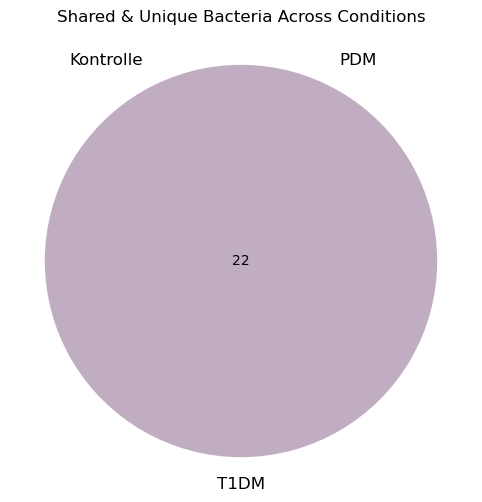

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Load the dataset
file_path = "level-6.csv"
df = pd.read_csv(file_path)

# Extract microbial abundance data (exclude metadata)
metadata_cols = ["index", "sample_information", "condition", "nikotin", "sex", "age_group", "AH"]
microbial_data = df.drop(columns=metadata_cols, errors='ignore')

# Extract only microbial taxa names (last part of taxonomy string)
def extract_species_name(taxonomy):
    """Extract the last part of a taxonomy string (genus name)."""
    return taxonomy.split(';')[-1].strip()

microbial_data.rename(columns={col: extract_species_name(col) for col in microbial_data.columns}, inplace=True)

# Remove empty column names ("")
microbial_data = microbial_data.loc[:, microbial_data.columns != ""]

# Identify presence/absence per condition (keep taxa with non-zero values)
pdm_taxa = set(microbial_data[df["condition"] == "pankreopriver Diabetes"].iloc[:, :-1].columns)
t1dm_taxa = set(microbial_data[df["condition"] == "Diabetes mellitus Typ1"].iloc[:, :-1].columns)
control_taxa = set(microbial_data[df["condition"] == "Kontrolle"].iloc[:, :-1].columns)

# Plot Venn diagram
plt.figure(figsize=(6, 6))
venn = venn3([control_taxa, pdm_taxa, t1dm_taxa], set_labels=("Kontrolle", "PDM", "T1DM"))

# Set custom colors
#venn.get_label_by_id("100").set_color("#E1812C")  # Kontrolle (Orange)
#venn.get_label_by_id("010").set_color("#3A923A")  # PDM (Green)
#venn.get_label_by_id("001").set_color("#3374A1")  # T1DM (Blue)

# Title
plt.title("Shared & Unique Bacteria Across Conditions")

# Show plot
plt.show()


/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Us

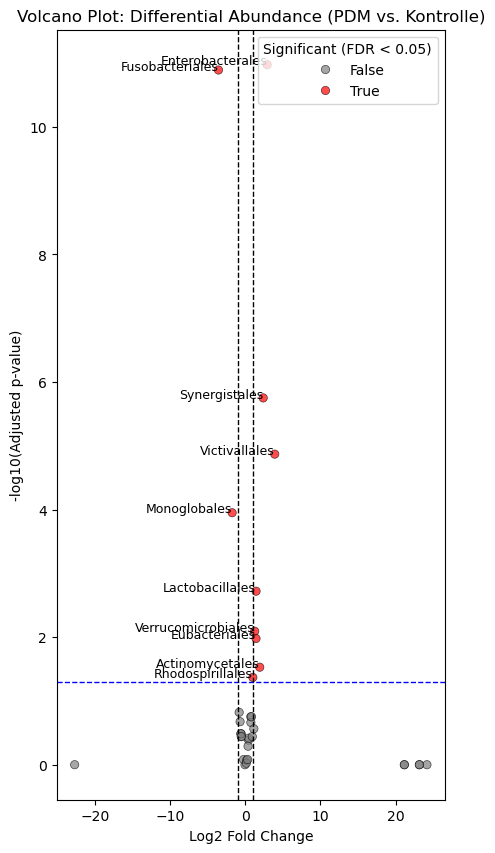

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Define the file path
file_path = "level-4.csv"

# Load the CSV file
df = pd.read_csv(file_path)

# Extract microbial abundance data (exclude metadata)
metadata_cols = ["index", "sample_information", "condition", "nikotin", "sex", "age_group", "AH"]
microbial_data = df.drop(columns=metadata_cols, errors='ignore')

# Extract only microbial taxa names (last part of taxonomy string)
def extract_species_name(taxonomy):
    """Extract the last part of a taxonomy string (genus name)."""
    return taxonomy.split(';')[-1].strip()

microbial_data.rename(columns={col: extract_species_name(col) for col in microbial_data.columns}, inplace=True)

# Remove empty column names ("")
microbial_data = microbial_data.loc[:, microbial_data.columns != ""]

# Add condition column back
microbial_data["condition"] = df["condition"]

# Filter for only "pankreopriver Diabetes" and "Kontrolle"
df_filtered = microbial_data[microbial_data["condition"].isin(["pankreopriver Diabetes", "Kontrolle"])].copy()

# Convert condition to binary (1 = PDM, 0 = Kontrolle)
df_filtered["condition"] = df_filtered["condition"].map({"pankreopriver Diabetes": 1, "Kontrolle": 0})

# Prepare results storage
results = []

# Perform differential abundance analysis (negative binomial regression like DESeq2)
for taxon in df_filtered.columns[:-1]:  # Exclude 'condition' column
    # Ensure values are numeric
    df_filtered[taxon] = pd.to_numeric(df_filtered[taxon], errors='coerce')

    # Fit a Negative Binomial Model
    try:
        model = smf.glm(f"{taxon} ~ condition", data=df_filtered, family=sm.families.NegativeBinomial()).fit()
        log_fold_change = model.params["condition"]
        p_value = model.pvalues["condition"]
        results.append((taxon, log_fold_change, p_value))
    except:
        continue  # Skip taxa where model fitting fails

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Taxon", "Log2 Fold Change", "p-value"])

# Adjust p-values using Benjamini-Hochberg (FDR correction)
results_df["Adjusted p-value"] = multipletests(results_df["p-value"], method="fdr_bh")[1]

# Create a Volcano Plot to visualize differential abundance results

# Define significance threshold
significance_threshold = 0.05

# Create a new column for significance labeling
results_df["Significance"] = results_df["Adjusted p-value"] < significance_threshold

# Create Volcano Plot
plt.figure(figsize=(5,10))
sns.scatterplot(
    x=results_df["Log2 Fold Change"],
    y=-np.log10(results_df["Adjusted p-value"]),
    hue=results_df["Significance"],
    palette={True: "red", False: "gray"},
    edgecolor="black",
    alpha=0.7
)

# Add labels for significant points
for i, row in results_df.iterrows():
    if row["Significance"]:
        plt.text(row["Log2 Fold Change"], -np.log10(row["Adjusted p-value"]), row["Taxon"], fontsize=9, ha='right')

# Labels and title
plt.axhline(-np.log10(significance_threshold), linestyle="--", color="blue", linewidth=1)  # Threshold line
plt.axvline(x=-logfoldchange_threshold, linestyle="--", color="black", linewidth=1)  # Log2FC negative threshold
plt.axvline(x=logfoldchange_threshold, linestyle="--", color="black", linewidth=1)  # Log2FC positive threshold
plt.xlabel("Log2 Fold Change")
plt.ylabel("-log10(Adjusted p-value)")
plt.title("Volcano Plot: Differential Abundance (PDM vs. Kontrolle)")
plt.legend(title="Significant (FDR < 0.05)", loc="upper right")

# Show plot
plt.show()


/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Us

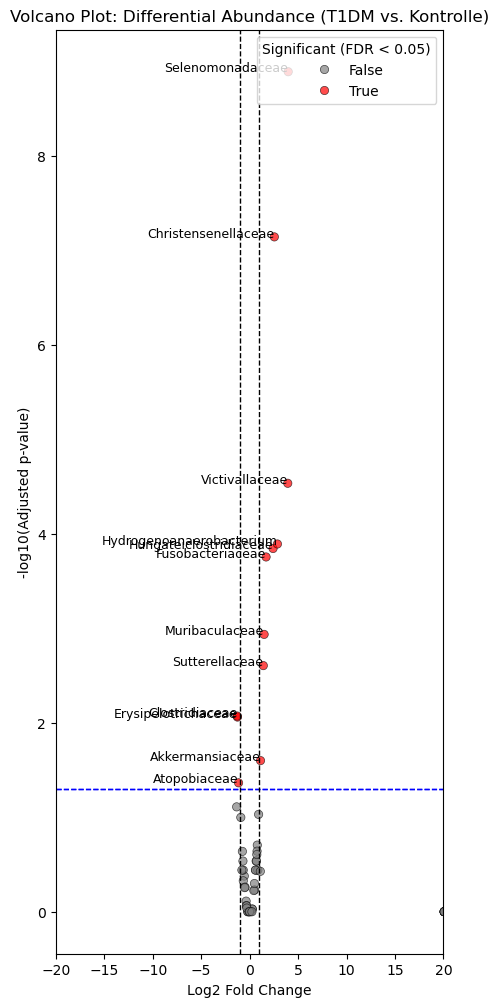

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests



# Define the file path
file_path = "level-5.csv"

# Load the CSV file
df = pd.read_csv(file_path)

# Extract microbial abundance data (exclude metadata)
metadata_cols = ["index", "sample_information", "condition", "nikotin", "sex", "age_group", "AH"]
microbial_data = df.drop(columns=metadata_cols, errors='ignore')

# Extract only microbial taxa names (last part of taxonomy string)
def extract_species_name(taxonomy):
    """Extract the last part of a taxonomy string (genus name)."""
    return taxonomy.split(';')[-1].strip()

microbial_data.rename(columns={col: extract_species_name(col) for col in microbial_data.columns}, inplace=True)

# Remove empty column names ("")
microbial_data = microbial_data.loc[:, microbial_data.columns != ""]

# Add condition column back
microbial_data["condition"] = df["condition"]

# Filter for only "pankreopriver Diabetes" and "Kontrolle"
df_filtered = microbial_data[microbial_data["condition"].isin(["Diabetes mellitus Typ1", "Kontrolle"])].copy()

# Convert condition to binary (1 = PDM, 0 = Kontrolle)
df_filtered["condition"] = df_filtered["condition"].map({"Diabetes mellitus Typ1": 1, "Kontrolle": 0})

# Prepare results storage
results = []

# Perform differential abundance analysis (negative binomial regression like DESeq2)
for taxon in df_filtered.columns[:-1]:  # Exclude 'condition' column
    # Ensure values are numeric
    df_filtered[taxon] = pd.to_numeric(df_filtered[taxon], errors='coerce')

    # Fit a Negative Binomial Model
    try:
        model = smf.glm(f"{taxon} ~ condition", data=df_filtered, family=sm.families.NegativeBinomial()).fit()
        log_fold_change = model.params["condition"]
        p_value = model.pvalues["condition"]
        results.append((taxon, log_fold_change, p_value))
    except:
        continue  # Skip taxa where model fitting fails

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Taxon", "Log2 Fold Change", "p-value"])

# Adjust p-values using Benjamini-Hochberg (FDR correction)
results_df["Adjusted p-value"] = multipletests(results_df["p-value"], method="fdr_bh")[1]

# Create a Volcano Plot to visualize differential abundance results

# Define significance threshold
significance_threshold = 0.05

# Create a new column for significance labeling
results_df["Significance"] = results_df["Adjusted p-value"] < significance_threshold

# Create Volcano Plot
plt.figure(figsize=(5,12))
sns.scatterplot(
    x=results_df["Log2 Fold Change"],
    y=-np.log10(results_df["Adjusted p-value"]),
    hue=results_df["Significance"],
    palette={True: "red", False: "gray"},
    edgecolor="black",
    alpha=0.7
)

# Add labels for significant points
for i, row in results_df.iterrows():
    if row["Significance"]:
        plt.text(row["Log2 Fold Change"], -np.log10(row["Adjusted p-value"]), row["Taxon"], fontsize=9, ha='right')

# Set x-axis limits
plt.xlim(-20, 20)



# Add threshold lines
plt.axhline(-np.log10(significance_threshold), linestyle="--", color="blue", linewidth=1)  # p-value threshold
plt.axvline(x=-logfoldchange_threshold, linestyle="--", color="black", linewidth=1)  # Log2FC negative threshold
plt.axvline(x=logfoldchange_threshold, linestyle="--", color="black", linewidth=1)  # Log2FC positive threshold
plt.xlabel("Log2 Fold Change")
plt.ylabel("-log10(Adjusted p-value)")
plt.title("Volcano Plot: Differential Abundance (T1DM vs. Kontrolle)")
plt.legend(title="Significant (FDR < 0.05)", loc="upper right")

# Show plot
plt.show()


In [44]:
results_df

,Taxon,Log2 Fold Change,p-value,Adjusted p-value,Significance
0,Lachnospirales,-0.509057,2.015071e-01,3.617806e-01,False
1,Oscillospirales,-0.553358,1.650267e-01,3.268220e-01,False
2,Enterobacterales,2.911679,3.026794e-13,1.059378e-11,True
3,Coriobacteriales,0.440221,2.702928e-01,4.113151e-01,False
4,Bacteroidales,-0.033899,9.322152e-01,9.990583e-01,False
5,Acidaminococcales,0.469704,2.407159e-01,3.829571e-01,False
6,Erysipelotrichales,-0.688360,8.449312e-02,2.112328e-01,False
7,Lactobacillales,1.434575,3.262278e-04,1.902995e-03,True
8,Monoglobales,-1.745245,1.598020e-05,1.118614e-04,True
9,Bifidobacteriales,-0.211737,5.954851e-01,8.281789e-01,False
